In [29]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim

In [31]:
import numpy as np

In [32]:
import sys
sys.path.append(initial_path)

from my_code import functions as f

In [33]:
torch.set_default_dtype(torch.float64)

# Data

In [34]:
file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list)/100
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [35]:
n_aminoacids = len(string_list[0])

In [36]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [37]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [38]:
# Define the dataset
input_data = torch.tensor(X, dtype=torch.float64) 
target_data = torch.tensor(Y, dtype=torch.float64).view(-1, 1)

# Define the validation set
input_validation = torch.tensor(X_validation, dtype=torch.float64)
target_validation = torch.tensor(Y_validation, dtype=torch.float64).view(-1, 1)

# Quantum node

In [39]:
import pennylane as qml

In [40]:
n_qubits = n_aminoacids
n_layers_block = 25
n_layers_embedding = 3
n_shots = 10000
# n_shots = None
dev = qml.device("default.qubit.torch", wires=n_qubits, shots=n_shots)


In [41]:
shape_weights_embedding = (n_layers_embedding, n_qubits, 2)
shape_weights_block_1 = (n_layers_block, n_qubits, 2)
shape_weights_block_2 = (n_layers_block, n_qubits//2, 2)

In [42]:
# size_weights = np.product(shape_weights_embedding) + np.product(shape_weights_block_1) + np.product(shape_weights_block_2)
size_weights = np.product(shape_weights_block_1) + np.product(shape_weights_block_2)

In [43]:
@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):

    weights_block_1 = weights[:np.product(shape_weights_block_1)].reshape(shape_weights_block_1)
    weights_block_2 = weights[np.product(shape_weights_block_1):].reshape(shape_weights_block_2)

    # embedding layer
    qml.AngleEmbedding(inputs, wires=range(n_qubits))

    #block
    for i in range(n_layers_block):
        # rotations for each qubit
        for j in range(n_qubits):
            qml.RY(weights_block_1[i,j,0], wires=j)
            qml.RZ(weights_block_1[i,j,1], wires=j)

        # ZZ rotation for neighboring qubits         
        for j in range(0,n_qubits,2): 
            qml.CNOT(wires=[j, (j+1)])

        # rotations for some qubits
        for j, w in enumerate(range(1, n_qubits, 4)): 
            qml.RY(weights_block_2[i,j,0], wires=w)
            qml.RZ(weights_block_2[i,j,1], wires=w)
            qml.RY(weights_block_2[i,j+1,0], wires=w+1)
            qml.RZ(weights_block_2[i,j+1,1], wires=w+1)
            qml.CNOT(wires=[w, (w+1)])

    # measurement
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [44]:
qnode([1,2,3,4], np.zeros((size_weights,)))

[tensor(0.5364), tensor(-0.2282), tensor(0.2280), tensor(0.6480)]

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

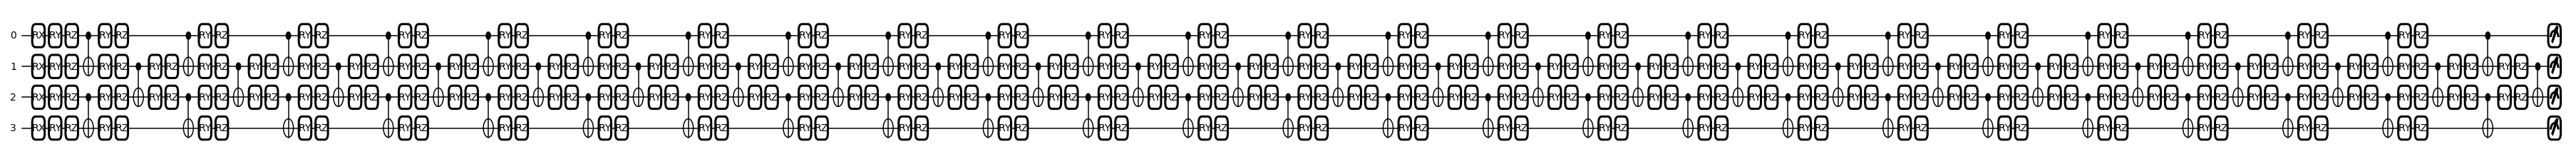

In [45]:
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(qnode, expansion_strategy="device")([i for i in range(n_qubits)], np.zeros((size_weights,)))
fig.set_size_inches((50,3))

In [46]:
weight_shapes = {"weights": (size_weights,)}

In [47]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

In [48]:
class QNodeFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input, qlayer):
        ctx.save_for_backward(input)
        ctx.qlayer = qlayer
        return qlayer(input)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        qlayer = ctx.qlayer
        epsilon = 0.01
        
        # Gradient w.r.t. input
        perturbation_input = (torch.rand_like(input) * 2 - 1) * epsilon
        positive_input = input + perturbation_input
        negative_input = input - perturbation_input
        
        loss_positive = qlayer(positive_input).sum()
        loss_negative = qlayer(negative_input).sum()
        
        gradient_input = (loss_positive - loss_negative) / (2 * epsilon) * perturbation_input
        gradient_input *= grad_output  # Incorporate grad_output due to chain rule

        # Gradient w.r.t. qlayer's parameters
        gradients_weights = []
        for p in qlayer.parameters():
            perturbation_weight = (torch.rand_like(p) * 2 - 1) * epsilon
            p.data += perturbation_weight

            loss_positive = qlayer(input).sum()
            loss_negative = qlayer(input).sum()

            gradient_weight = (loss_positive - loss_negative) / (2 * epsilon) * perturbation_weight / epsilon
            gradients_weights.append(gradient_weight * grad_output.sum())  # Weighting by grad_output

            p.data -= perturbation_weight  # Reset to original value

        # Update gradients for qlayer's parameters
        for p, grad in zip(qlayer.parameters(), gradients_weights):
            if p.grad is None:
                p.grad = grad.detach()
            else:
                p.grad += grad.detach()

        return gradient_input, None

# Wrapper around the custom autograd function
class CustomQLayer(torch.nn.Module):
    def __init__(self, qlayer):
        super(CustomQLayer, self).__init__()
        self.qlayer = qlayer

    def forward(self, x):
        return QNodeFunction.apply(x, self.qlayer)

# Hybrid model

In [49]:
input_dim = input_data.size(1)

In [50]:
n_pre_classical_layers = 4
layers_dim = np.linspace(n_qubits, input_dim, 4).astype(int)

In [51]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), nn.Sigmoid()]
layers += [nn.Linear(layers_dim[0], layers_dim[0])]

layers += [CustomQLayer(qlayer)]

for i in range(len(layers_dim)-1):
    layers += [nn.Linear(layers_dim[i], layers_dim[(i+1)]), nn.Sigmoid()]
layers += [nn.Linear(layers_dim[-1], 1)]


Net = nn.Sequential(*layers)

In [52]:
# Create an instance of the network
model = Net

In [53]:
import time

In [55]:
# time
start_time = time.time()


# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.05)  # Adam optimizer with learning rate 0.001
# optimizer = optim.SGD(model.parameters(), lr=0.05)

# Training loop
num_epochs = 25
batch_size = 32

#validation data
i_validation = input_validation[::10] #we take only 10% of the validation data, to speed up the process
t_validation = target_validation[::10] 

losses = []
losses_epochs = [0]
losses_epochs_validation = [0]

losses_epochs[-1] = criterion(model(input_data), target_data).item()
losses_epochs_validation[-1] = criterion(model(i_validation), t_validation).item()
# print the loss of 3 strings of the validation data
for i in range(3):
    prediction = model(i_validation[i])
    target = t_validation[i]
    print('\t Validation string, \t i: {}; \t prediction: {:.4f}, \t target: {:.4f}, \t loss: {:.4f}'.format(i, prediction.item(), target.item(), criterion(prediction, target).item()))

print('Epoch [{}/{}], Loss: {:.4f}, Loss validation: {:.4f}'.format(0, num_epochs, losses_epochs[-1], losses_epochs_validation[-1]))

for epoch in range(num_epochs):
    # Shuffle the dataset
    indices = torch.randperm(input_data.size(0))
    input_data = input_data[indices]
    target_data = target_data[indices]

    losses_epochs.append(0)

    # Mini-batch training
    for i in range(0, input_data.size(0), batch_size):

        inputs = input_data[i:i+batch_size]
        targets = target_data[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, targets)

        import ipdb
        ipdb.set_trace()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss
        losses.append(loss.item())

        print('- Epoch [{}/{}], i: [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, input_data.size(0), loss.item()), end='\r')

        # add to the epoch loss
        losses_epochs[-1] += loss.item() 

    # divide the epoch loss by the number of batches, to get the average loss
    losses_epochs[-1] /= (input_data.size(0)/batch_size)

    # Validation
    losses_epochs_validation.append(criterion(model(i_validation), t_validation).item()) 

    # print the loss of 3 strings of the validation data
    for i in range(3):
        prediction = model(i_validation[i])
        target = t_validation[i]
        print('\t Validation string, \t i: {}; \t prediction: {:.4f}, \t target: {:.4f}, \t loss: {:.4f}'.format(i, prediction.item(), target.item(), criterion(prediction, target).item()))

    # time
    # Compute elapsed time and remaining time
    elapsed_time = time.time() - start_time
    avg_time_per_epoch = elapsed_time / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    estimated_remaining_time = avg_time_per_epoch * remaining_epochs

    # Convert remaining time to hours, minutes, and seconds for better readability
    hours, remainder = divmod(estimated_remaining_time, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Print the loss and remaining time for this epoch
    print('Epoch [{}/{}], Loss: {:.4f}, Loss validation: {:.4f}, Time remaining: ~{}h {}m {:.0f}s'.format(
        epoch+1, num_epochs, losses_epochs[-1], losses_epochs_validation[-1], hours, minutes, seconds))


	 Validation string, 	 i: 0; 	 prediction: 0.4438, 	 target: -0.4201, 	 loss: 0.7462
	 Validation string, 	 i: 1; 	 prediction: 0.4433, 	 target: 0.1226, 	 loss: 0.1028
	 Validation string, 	 i: 2; 	 prediction: 0.4428, 	 target: -0.6795, 	 loss: 1.2597
Epoch [0/25], Loss: 1.5813, Loss validation: 1.4791


ModuleNotFoundError: No module named 'ipdb'

In [ ]:
model[0](i_validation[0])

tensor([-1.2673, -0.6268, -0.8365, -0.6149,  0.4467, -0.0680, -0.8557, -0.6668,
        -0.3395, -0.9603, -0.0111, -0.3238, -0.6356, -1.0645,  0.1326, -0.2071,
         0.9985, -0.5521, -0.1335, -0.4557, -1.0734,  0.3739, -1.0039,  0.2931,
        -1.3679, -0.6980, -0.7986, -1.2575, -1.1648,  0.1183,  0.4042, -1.3090,
        -1.2719, -0.8513, -1.2637, -0.2975, -0.7622, -1.8730, -1.0047, -0.2669,
        -0.7882, -1.1492, -0.4335, -0.8839, -1.4969, -1.1193, -1.3921,  1.0702,
        -1.7162, -1.1924, -0.5851, -0.9550], grad_fn=<AddBackward0>)

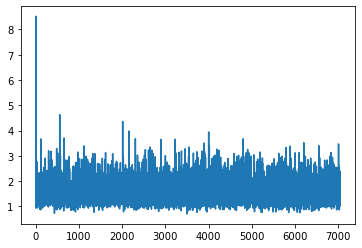

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

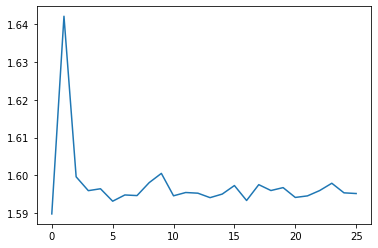

In [ ]:
#plot the loss
import matplotlib.pyplot as plt
plt.plot(losses_epochs)
plt.show()

In [ ]:
import os

name_notebook = "0731-small_hybrid_model_Allqm_shots.ipynb"  

output_filename = initial_path + "Notebooks/models/"+ name_notebook[:4] +"/" + name_notebook[:-6] + "_0.pth"

#check if the output file already exists
while os.path.exists(output_filename):
    print("The file {} already exists".format(output_filename))
    output_filename = output_filename[:-5] + str(int(output_filename[-5]) + 1)
    print("Trying to save the file as {}".format(output_filename))


torch.save(model.state_dict(), output_filename)

In [ ]:
!cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main 92667d0] data trained model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Notebooks/models/0731/0731-small_hybrid_model_Allqm_shots_0.pth
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 24 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (6/6), 89.37 KiB | 6.88 MiB/s, done.
Total 6 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:raulconchello/peptide-QML.git
   06d0ee4..92667d0  main -> main


In [ ]:
avg_loss = 0
for x, (i, t) in enumerate(zip((input_validation), target_validation)):
    out = model(i)
    loss = criterion(out, t)
    avg_loss += loss/len(target_validation)
    print('i: {}, \t target: {:.3f}, \t output: {:.3f}, \t loss: {:.3f}'.format(x, t.item(), out.item(), loss))

print('Average loss: {:.3f}'.format(avg_loss))

i: 0, 	 target: -0.879, 	 output: 0.262, 	 loss: 1.303
i: 1, 	 target: 1.533, 	 output: 0.262, 	 loss: 1.613
i: 2, 	 target: 0.908, 	 output: 0.262, 	 loss: 0.417
i: 3, 	 target: 2.895, 	 output: 0.262, 	 loss: 6.930
i: 4, 	 target: -0.794, 	 output: 0.262, 	 loss: 1.116
i: 5, 	 target: -0.680, 	 output: 0.262, 	 loss: 0.888
i: 6, 	 target: 2.630, 	 output: 0.262, 	 loss: 5.606
i: 7, 	 target: 0.725, 	 output: 0.262, 	 loss: 0.214
i: 8, 	 target: -0.550, 	 output: 0.262, 	 loss: 0.661
i: 9, 	 target: -0.604, 	 output: 0.262, 	 loss: 0.751
i: 10, 	 target: -0.722, 	 output: 0.262, 	 loss: 0.968
i: 11, 	 target: 0.456, 	 output: 0.262, 	 loss: 0.037
i: 12, 	 target: 1.778, 	 output: 0.262, 	 loss: 2.298
i: 13, 	 target: -0.785, 	 output: 0.262, 	 loss: 1.097
i: 14, 	 target: 2.904, 	 output: 0.262, 	 loss: 6.980
i: 15, 	 target: -0.355, 	 output: 0.262, 	 loss: 0.381
i: 16, 	 target: 0.299, 	 output: 0.262, 	 loss: 0.001
i: 17, 	 target: 2.053, 	 output: 0.262, 	 loss: 3.206
i: 18, 	 tar